In [ ]:
#| hide
#skip
! [ -e /content ] && pip install -Uqq pyndamics3 emcee # upgrade pyndamics3 on colab

In [ ]:
%matplotlib inline
from pylab import *
from sie.core import *

In [ ]:
def plot_distribution(dist,label=r'\bar{x}',fill_left=None,xlim=None):
    import pylab as py
    qmin=.0001
    qmax=1-qmin

    if xlim is None:
        xmin=dist.D.ppf(qmin)
        xmax=dist.D.ppf(qmax)
    else:
        xmin,xmax=xlim

    x=linspace(xmin,xmax,200)
    y=dist.D.pdf(x)

    figure(figsize=(16,5))

    plot(x,y)

    v=dist.D.ppf([2.5/100,50/100,97.5/100])
    label=label
    py.title(r'$\hat{%s}^{97.5}_{2.5}=%.3f^{%.3f}_{%.3f}$' % (label,v[1],v[2],v[0]))
    py.ylabel(r'$p(%s|{\rm true\,\, value})$' % label)
    py.xlabel(r'$%s$' % label)

    if fill_left:
        x1=x.min()
        x2=fill_left
        xf=linspace(x1,x2,100)
        yf=dist.D.pdf(xf)
        fill_between(xf,yf,facecolor='red', alpha=0.2)   
        plot(xf,yf,'r-')    
        text(x.min(),0.2,'area = %.4f' % dist.D.cdf(x2))

In [ ]:
from sie.mcmc import StatsModel

From my talk, slides available here:  https://bblais.github.io/posts/2022/Nov/08/one-rule-to-rule-them-all/

## True value with known noise

- Data: $\{x_i\}=\{12,14,16\}, \sigma=1$
- Question: Is the true (population) value , $\mu$ , less than 13?

### Frequentist Approach

Uses a z-test.

In [ ]:
from sie.distributions import Normal

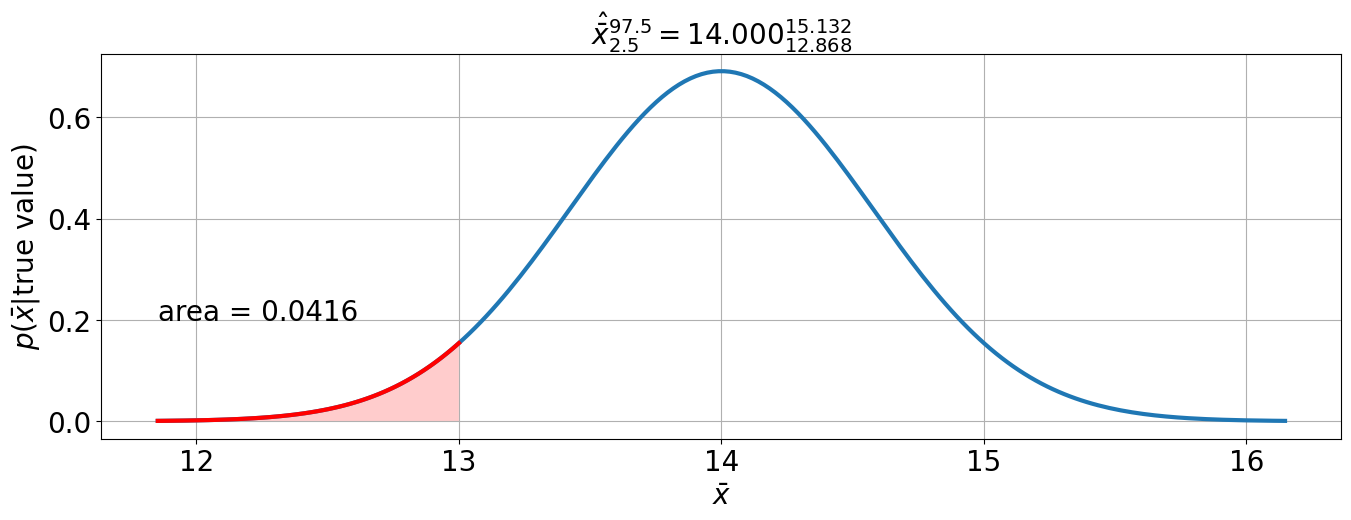

In [ ]:
x=[12,14,16]
σ=1
N=len(x)
dist=Normal(mean=mean(x),std=σ/sqrt(N))

plot_distribution(dist,fill_left=13)

### Bayesian Approach

In [ ]:
x=array([12,14,16])
model=StatsModel()
model.add_data(x=x)
model.add("μ ~ Normal(0,50)")  # really broad prior
model.add("x ~ Normal(μ,1)")


Sampling Prior...
Done.
0.18 s
Running MCMC...
Done.
1.30 s


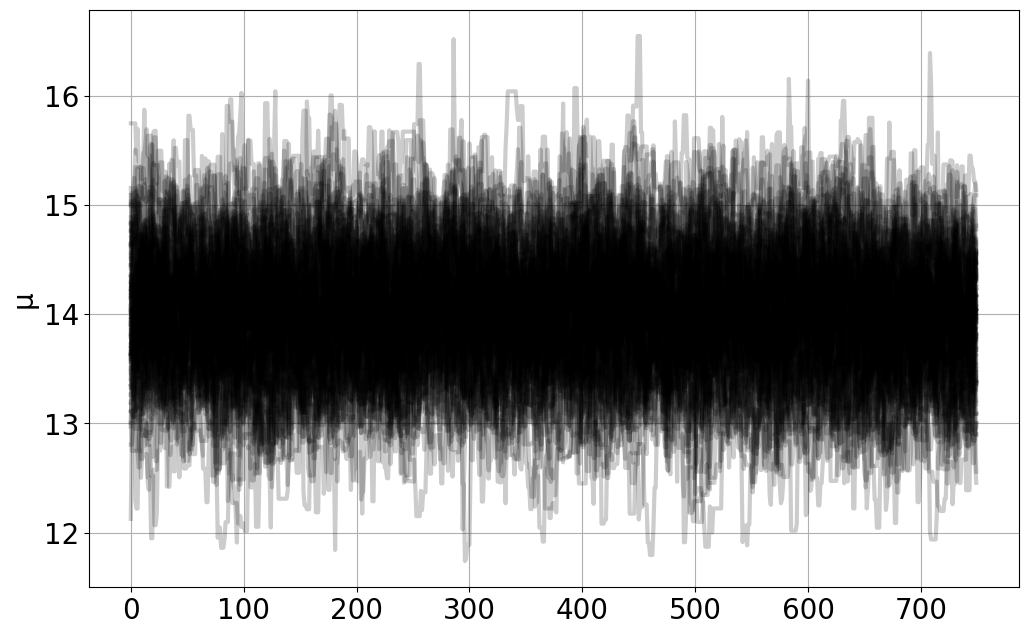

In [ ]:
model.run_mcmc(1000)
model.plot_chains()  # this is for debugging/making sure things are working

Text(11.5, 0.4, 'P(μ<13)=0.0396')

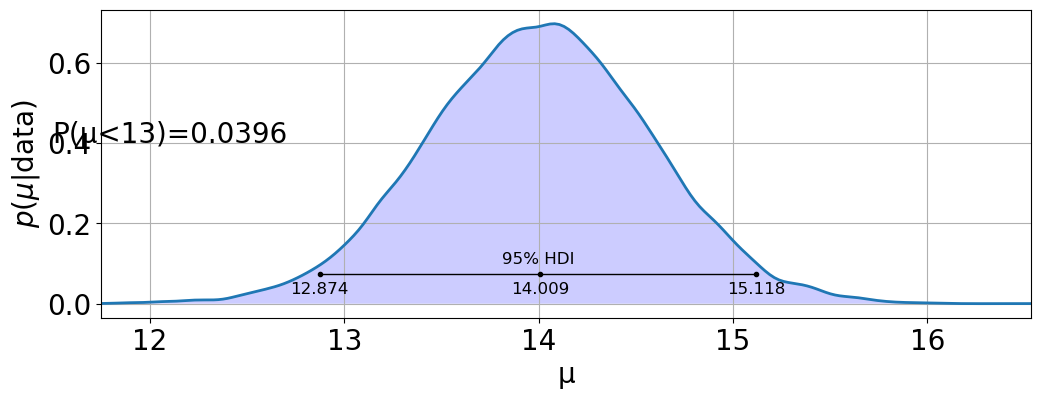

In [ ]:
model.plot_distributions()
text(11.5,.4,f"P(μ<13)={model.P('μ<13'):.3}")

In [ ]:
model.P("μ<13")

0.03964

## True value with unknown noise

- Data: $\{x_i\}=\{12,14,16\}$
- Question: Is the true (population) value , $\mu$ , less than 13?

### Frequentist Approach

Uses a Student-T test.

In [ ]:
from sie.distributions import StudentT

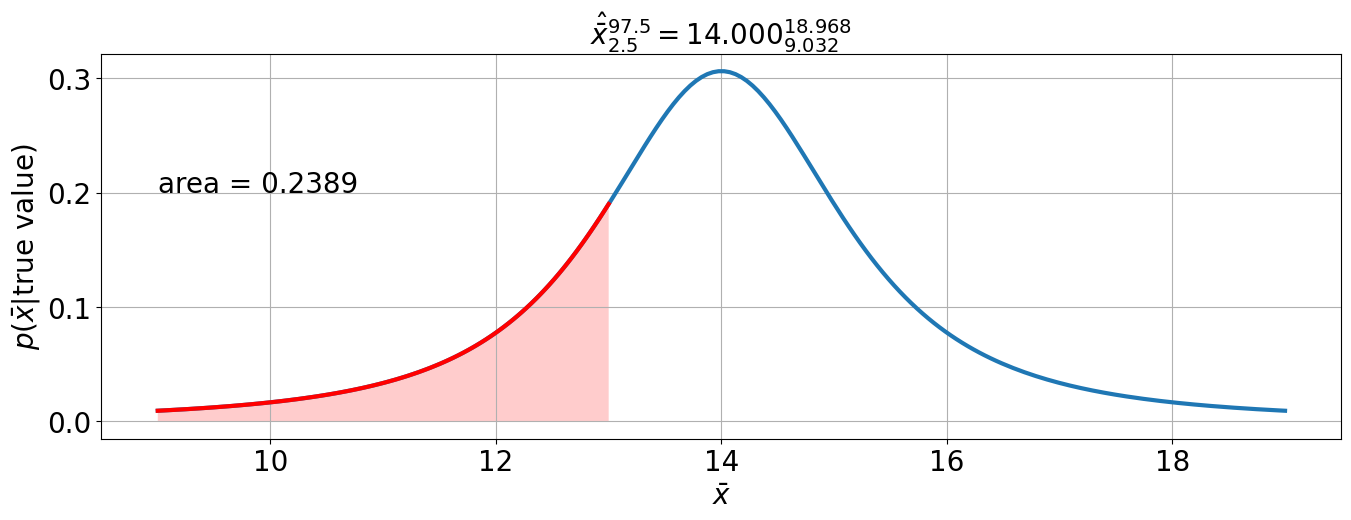

In [ ]:
x=[12,14,16]
dof=len(x)

dist=StudentT(mean=mean(x),
              std=std(x)/sqrt(N-1),
              dof=N-1)

plot_distribution(dist,fill_left=13,xlim=[9,19])

### Bayesian Approach

In [ ]:
x=array([12,14,16])
model=StatsModel()
model.add_data(x=x)
model.add("μ ~ Uniform(-50,50)")  # really broad prior
model.add("σ ~ Jeffreys()")
model.add("x ~ Normal(μ,σ)")


In [ ]:
model.run_mcmc(2000,repeat=2)
#model.plot_chains()

Sampling Prior...
Done.
0.13 s
Running MCMC 1/2...
Done.
2.37 s
Samples
Running MCMC 2/2...
Done.
2.46 s
Samples


Text(2, 0.1, 'P(μ<13)=0.232')

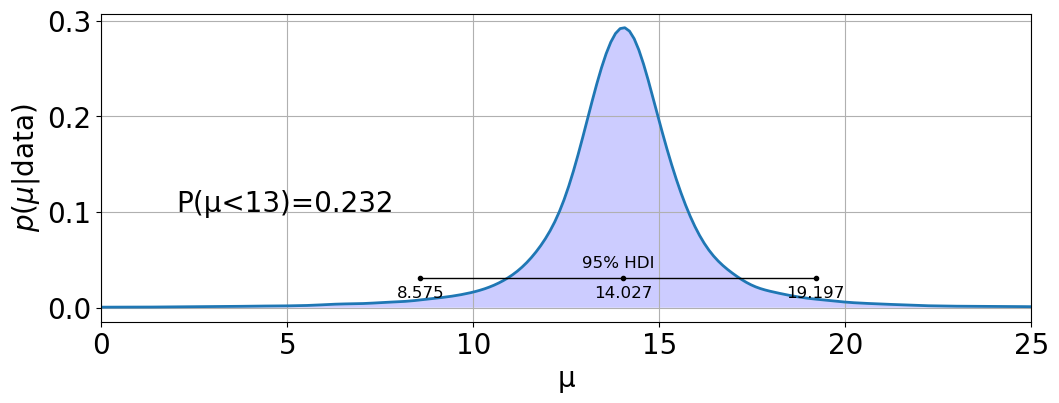

In [ ]:
model.plot_distributions('μ',xlim={'μ':[0,25],'σ':[0,30]})
text(2,.1,f"P(μ<13)={model.P('μ<13'):.3}")

and we get other comparisons for free..

Text(7.5, 0.1, 'P(σ>5)=0.151')

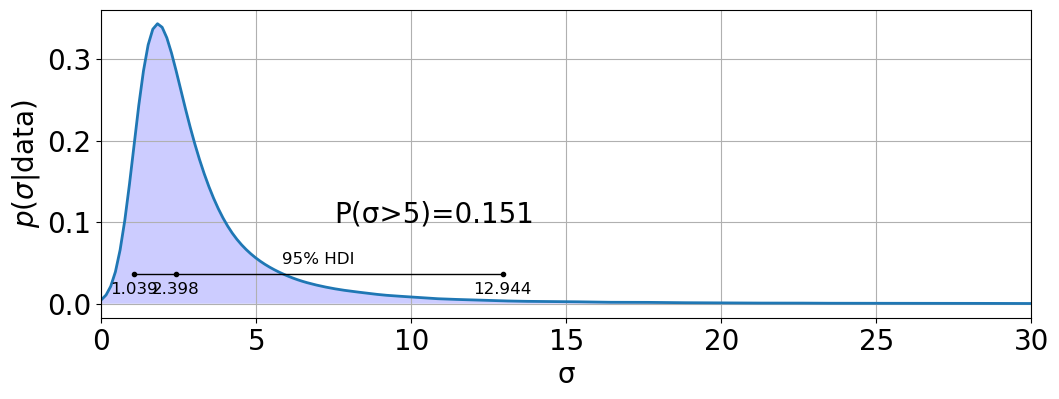

In [ ]:
model.plot_distributions('σ',xlim={'μ':[0,25],'σ':[0,30]})
text(7.5,.1,f"P(σ>5)={model.P('σ>5'):.3}")

## True value with unknown *Cauchy-distributed* noise

- Data: $\{x_i\}=\{12,14,16\}$
- Question: Is the true (population) value , $\mu$ , less than 13?

### Frequentist Approach

**There is no frequentist approach for this one.  The Cauchy distribution breaks all of the frequentist theorems, including the Central Limit Theorem.**

https://en.wikipedia.org/wiki/Cauchy_distribution

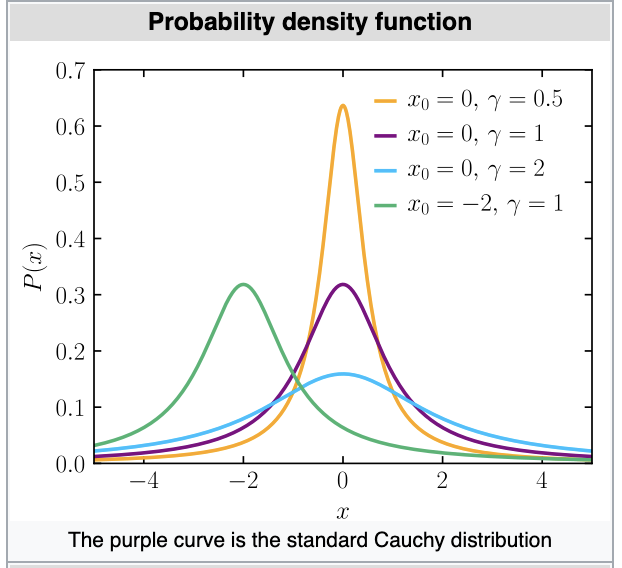

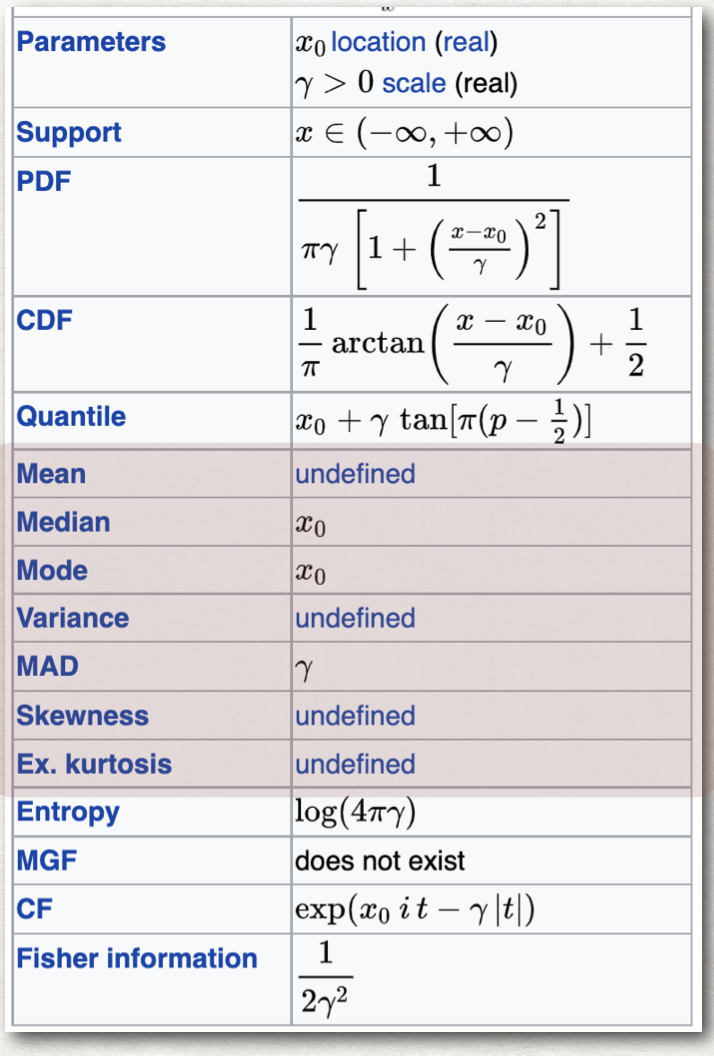

### Bayesian Approach

We only need to change the form of the noise.  We rename the noise parameter, only to be consistent with the standard notation.

In [ ]:
x=array([12,14,16])
model=StatsModel()
model.add_data(x=x)
model.add("μ ~ Uniform(-50,50)")  # really broad prior
model.add("γ ~ Jeffreys()")
model.add("x ~ Cauchy(μ,γ)")


In [ ]:
model.run_mcmc(2000,repeat=2)
#model.plot_chains()

Sampling Prior...
Done.
0.13 s
Running MCMC 1/2...
Done.
2.29 s
Samples
Running MCMC 2/2...
Done.
2.34 s
Samples


Text(2, 0.1, 'P(μ<13)=0.262')

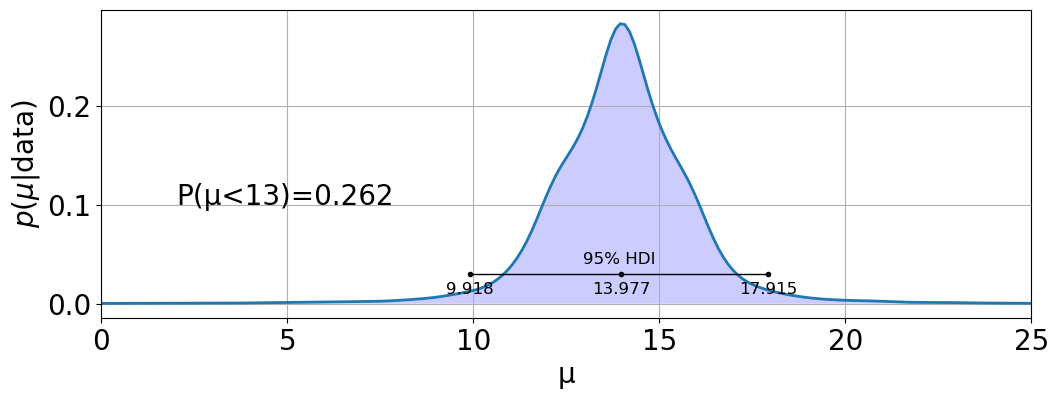

In [ ]:
model.plot_distributions('μ',xlim={'μ':[0,25],'σ':[0,30]})
text(2,.1,f"P(μ<13)={model.P('μ<13'):.3}")

## True value with exponential distribution 

From Jaynes "Confidence Intervals" 1976.  

> A device will operate without failure for a time, $\theta$ , because of a protective
chemical inhibitor injected into it; but at time, $\theta$ , the supply of this chemical is
exhausted, and failures then commence, following the exponential failure law. It is not
feasible to observe the depletion of this inhibitor directly; one can observe only the
resulting failures. From data on actual failure times, estimate the time of guaranteed
safe operation by a confidence interval. Here we have a continuous sample space, and
we are to estimate a location parameter, $\theta$ , from the sample values, $\{x_i\}=\{12,14,16\}$.


- Data: $\{x_i\}=\{12,14,16\}$
- Question: What is the best estimate of the failure time, $\theta$?

### Frequentist Approach

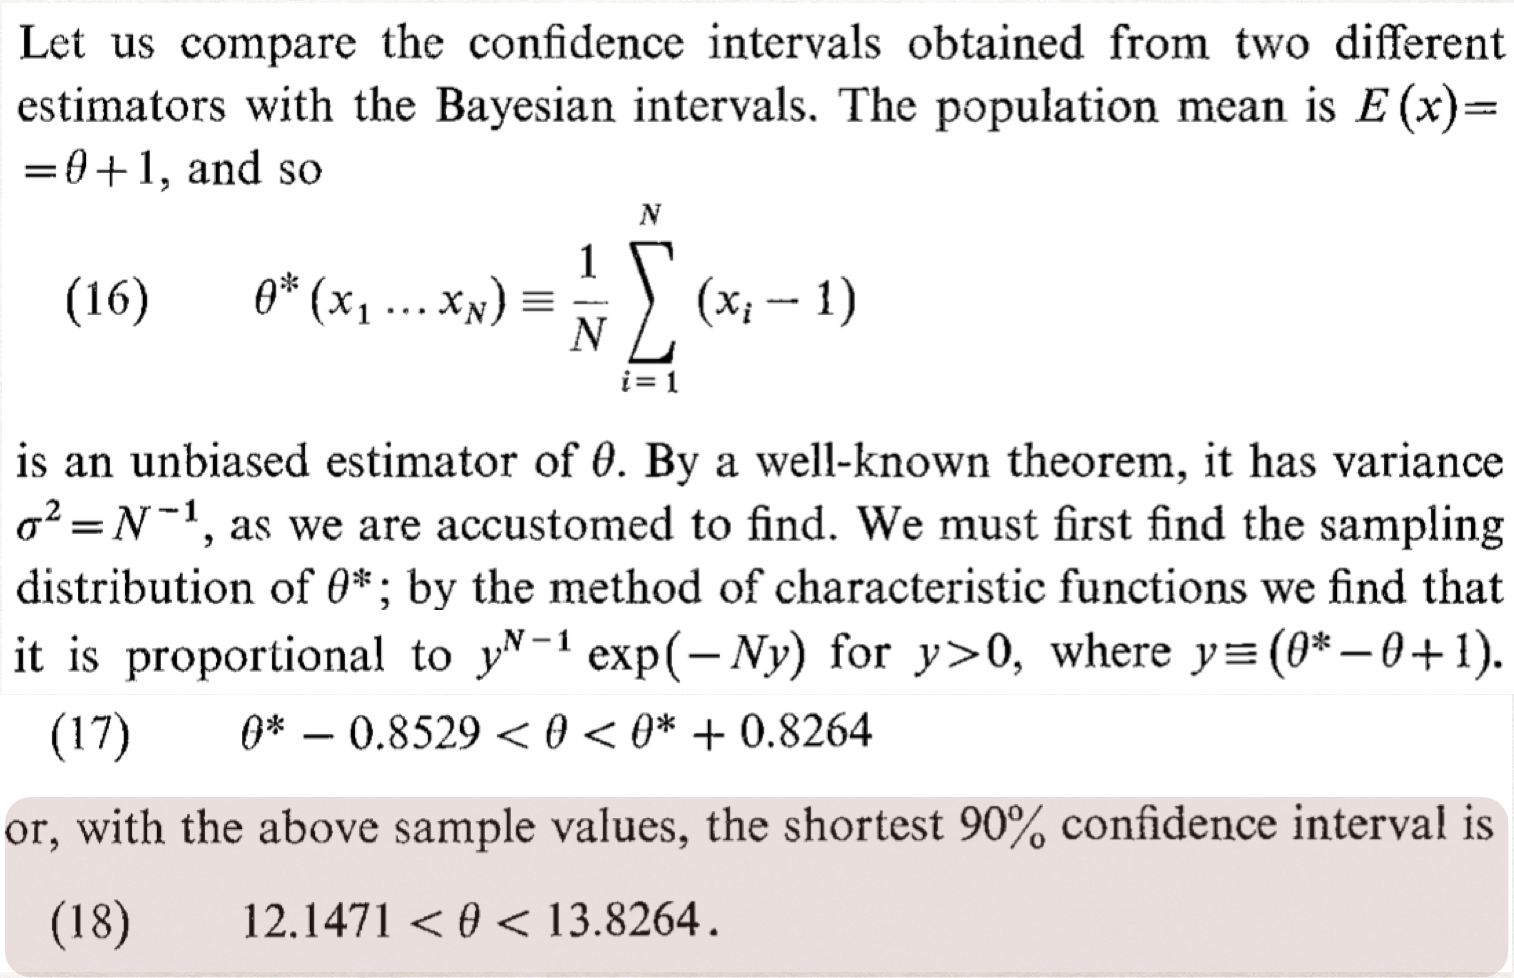

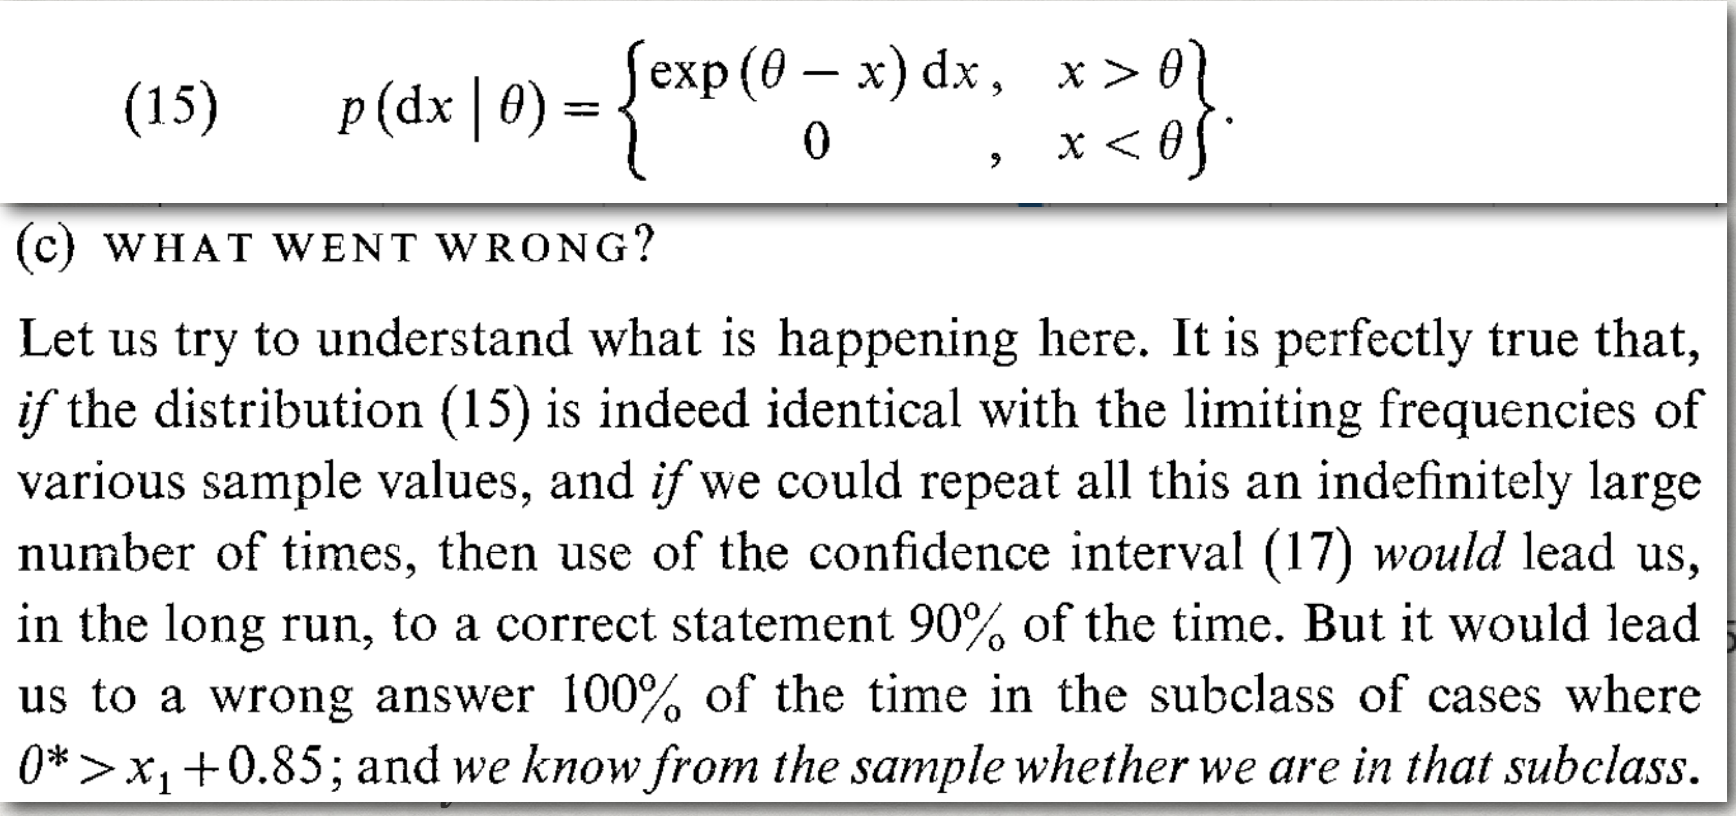

### Bayesian Approach -- this one is broken right now.  



In [ ]:
x=array([12,14,16])
model=StatsModel()
model.add_data(x=x)
model.add("θ ~ Uniform(-50,50)")  # really broad prior
model.add("x ~ Exponential(1,offset=θ)")



In [ ]:
# model.run_mcmc(2000,repeat=2)
# model.plot_chains()

## Anscombe's Quartet - Linear Regression

In [ ]:
xy1="""
X	Y
10	8.04
8	6.95
13	7.58
9	8.81
11	8.33
14	9.96
6	7.24
4	4.26
12	10.84
7	4.82
5	5.68
"""

xy2="""
X	Y
10	9.14
8	8.14
13	8.74
9	8.77
11	9.26
14	8.1
6	6.13
4	3.1
12	9.13
7	7.26
5	4.74
"""

xy3="""
X	Y
10	7.46
8	6.77
13	12.74
9	7.11
11	7.81
14	8.84
6	6.08
4	5.39
12	8.15
7	6.42
5	5.73
"""

xy4="""
X	Y
8	6.58
8	5.76
8	7.71
8	8.84
8	8.47
8	7.04
8	5.25
19	12.5
8	5.56
8	7.91
8	6.89
"""

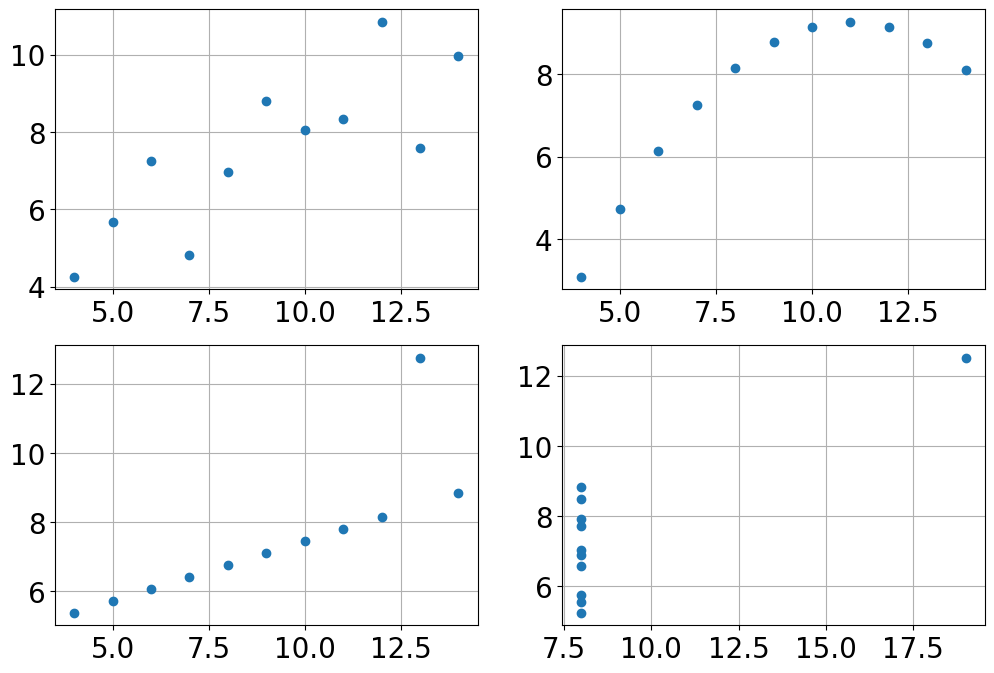

In [ ]:
for i,xy in enumerate([xy1,xy2,xy3,xy4]):
    subplot(2,2,i+1)
    x,y=array([_.split() for _ in xy.strip().split('\n')[1:]],dtype=float).T
    plot(x,y,'o')    

In [ ]:
xy=xy1
x,y=array([_.split() for _ in xy.strip().split('\n')[1:]],dtype=float).T


model=StatsModel()
model.add_data(x=x,y=y)
model.add("m ~ Normal(0,10)")
model.add("b ~ Normal(0,10)")
model.add("σ ~ Jeffreys()")
model.add("y ~ Normal(m*x+b,σ)")
model


Parameters
----------
    {'m': m, 'b': b, 'σ': σ}
Extra
-----
    []
Data
----
    ['x', 'y']
Prior
-----
    ['m ~ Normal(0,10)', 'b ~ Normal(0,10)', 'σ ~ Jeffreys()']
Likelihood
----------
    []
Data Parameters
---------------
    ['y ~ Normal(m*x+b,σ)']
        

Sampling Prior...
Done.
0.36 s
Running MCMC 1/3...
Done.
1.68 s
Samples
Running MCMC 2/3...
Done.
1.71 s
Samples
Running MCMC 3/3...
Done.
1.67 s
Samples


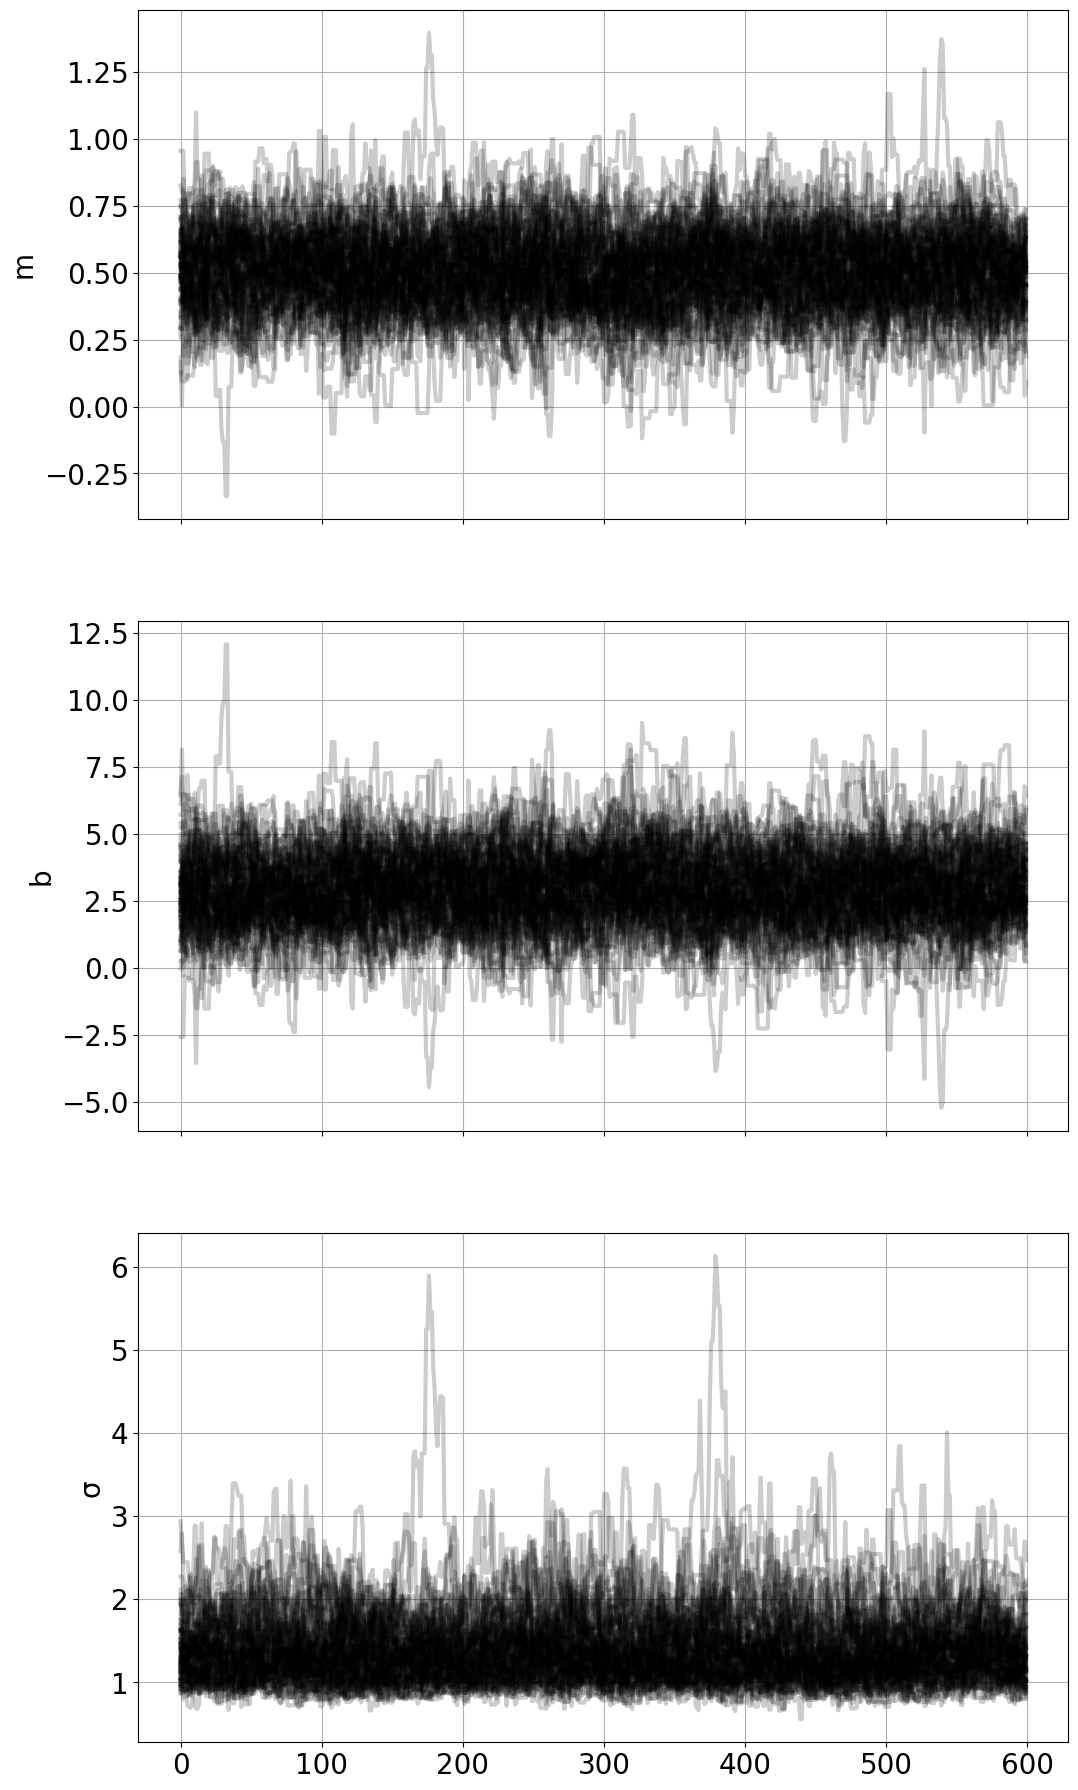

In [ ]:
model.run_mcmc(800,repeat=3)
model.plot_chains()

Sampling Prior...
Done.
0.34 s
Running MCMC 1/2...
Done.
1.68 s
Samples
Running MCMC 2/2...
Done.
1.68 s
Samples
Sampling Prior...
Done.
0.34 s
Running MCMC 1/2...
Done.
1.67 s
Samples
Running MCMC 2/2...
Done.
1.66 s
Samples
Sampling Prior...
Done.
0.33 s
Running MCMC 1/2...
Done.
1.70 s
Samples
Running MCMC 2/2...
Done.
1.65 s
Samples
Sampling Prior...
Done.
0.34 s
Running MCMC 1/2...
Done.
1.65 s
Samples
Running MCMC 2/2...
Done.
1.65 s
Samples


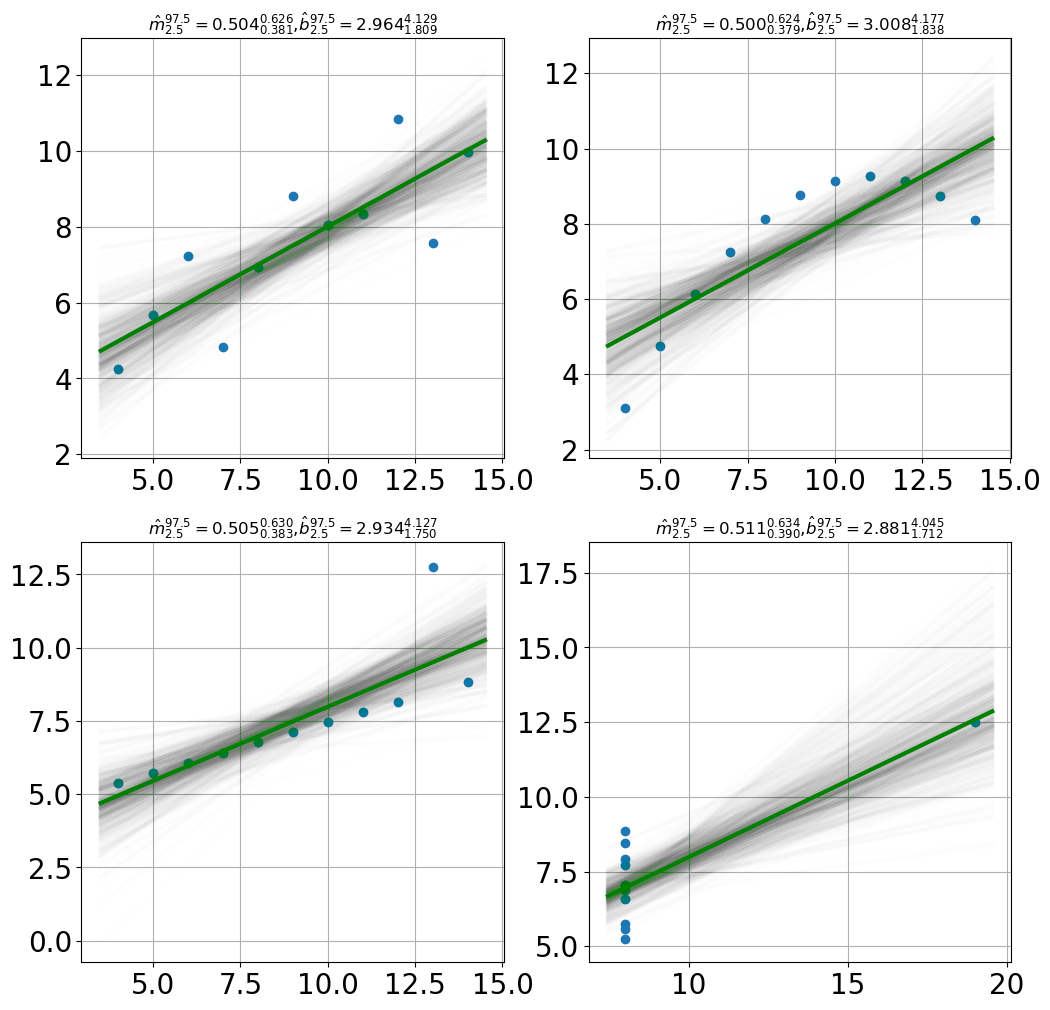

In [ ]:
figure(figsize=(12,12))
for i,xy in enumerate([xy1,xy2,xy3,xy4]):
    subplot(2,2,i+1)
    x,y=array([_.split() for _ in xy.strip().split('\n')[1:]],dtype=float).T
    
    data=x,y
    model=StatsModel()
    model.add_data(x=x,y=y)
    model.add("m ~ Normal(0,10)")
    model.add("b ~ Normal(0,10)")
    model.add("σ ~ Jeffreys()")
    model.add("y ~ Normal(m*x+b,σ)"               )
    
    model.run_mcmc(800,repeat=2)
    
    
    plot(x,y,'o')    
    xl=gca().get_xlim()
    xx=linspace(xl[0],xl[1],100)
    
    for m,b in model.sample_iterator('m','b'):
        yy=m*xx+b
        plot(xx,yy,'g-',alpha=0.002)

    m,b=model.best_estimates()['m'][1],model.best_estimates()['b'][1]
    yy=m*xx+b
    plot(xx,yy,'g-')
    
    S=[]
    for key,label in zip(['m','b'],['m','b']):
        v=model.best_estimates()[key].ravel()
        S.append(r'$\hat{%s}^{97.5}_{2.5}=%.3f^{%.3f}_{%.3f}$' % (label,v[1],v[2],v[0]))

    title(",".join(S),fontsize=12)
    
    

### Same process but with Student-T noise, a la Kruschke

Sampling Prior...
Done.
0.43 s
Running MCMC 1/2...
emcee: Exception while calling your likelihood function:
  params: [ 4.69280529e+05 -7.11162783e+05  4.41227944e+12 -1.58513079e+13]
  args: []
  kwargs: {}
  exception:


/Users/bblais/Documents/Git/sie/sie/mcmc.py:248: RuntimeWarning: invalid value encountered in log
  values=N*(gammaln((df+1)/2.0)-0.5*log(df*np.pi)-gammaln(df/2.0)-np.log(sd))+(-(df+1)/2.0)*np.log(1+t**2/df)
Traceback (most recent call last):
  File "/opt/anaconda3/envs/work/lib/python3.11/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/bblais/Documents/Git/sie/sie/mcmc.py", line 644, in __call__
    return self._lnposterior(θ)
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/bblais/Documents/Git/sie/sie/mcmc.py", line 639, in _lnposterior
    _value+=self._lnlikelihood(θ,self.data,self.slices,self.extra_params)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 42, in _lnlikelihood
  File "/Users/bblais/Documents/Git/sie/sie/mcmc.py", line 251, in _StudentT
    raise ValueError('NaN in StudentT',df,mu,sd)
ValueError: ('NaN 

ValueError: ('NaN in StudentT', array([-1.58513079e+13]), array([3981642.50739107, 3043081.44929077, 5389484.09454152,
       3512361.97834092, 4450923.03644122, 5858764.62359167,
       2104520.39119047, 1165959.33309017, 4920203.56549137,
       2573800.92024062, 1635239.86214032]), array([4.41227944e+12]))

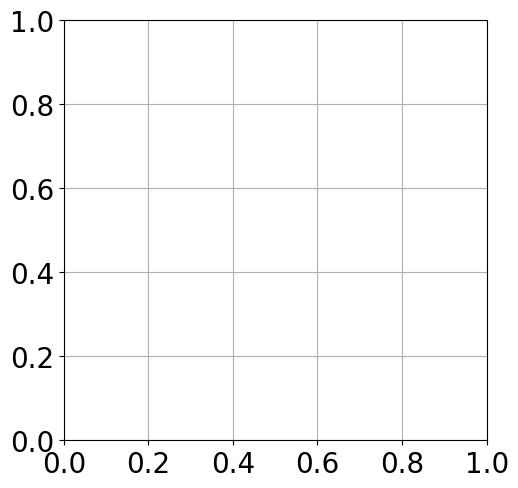

In [ ]:
figure(figsize=(12,12))
for i,xy in enumerate([xy1,xy2,xy3,xy4]):
    subplot(2,2,i+1)
    x,y=array([_.split() for _ in xy.strip().split('\n')[1:]],dtype=float).T
    
    data=x,y
    model=StatsModel()
    model.add_data(x=x,y=y)
    model.add("m ~ Normal(0,10)")
    model.add("b ~ Normal(0,10)")
    model.add("σ ~ Jeffreys()")
    model.add("ν ~ Exponential(29,offset=1)")
    model.add("y ~ StudentT(ν,m*x+b,σ)"               )
    
    model.run_mcmc(800,repeat=2)
    
    
    plot(x,y,'o')    
    xl=gca().get_xlim()
    xx=linspace(xl[0],xl[1],100)
    
    for m,b in model.sample_iterator('m','b'):
        yy=m*xx+b
        plot(xx,yy,'g-',alpha=0.002)

    m,b=model.best_estimates()['m'][1],model.best_estimates()['b'][1]
    yy=m*xx+b
    plot(xx,yy,'g-')
    
    S=[]
    for key,label in zip(['m','b'],['m','b']):
        v=model.best_estimates()[key].ravel()
        S.append(r'$\hat{%s}^{97.5}_{2.5}=%.3f^{%.3f}_{%.3f}$' % (label,v[1],v[2],v[0]))

    title(",".join(S),fontsize=12)
    
    